In [1]:
from NeuralNetwork import NeuralNet
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax import jit

In [2]:
@jit
def FrankeFunction(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Franke's function for evaluating methods.

    inputs:
        x (np.array): values in x direction

        y (np.array): values in y direction

    returns:
        (np.array) values in z direction
    """

    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) -
                          0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-((9 * x - 7) ** 2) / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-((9 * x - 4) ** 2) - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

In [3]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y).reshape(-1, 1)
X = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))

I0000 00:00:1700345672.749999       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
values = (X_train, X_test, z_train, z_test)

In [14]:
from typing import Callable
from CostFuncs import CostOLS_fast
from Schedules import Scheduler
from Activators import sigmoid, identity
from NeuralNetwork import NeuralNet
from pathlib import Path
from plotutils import plot_Franke, plot_validation_train

basePath = Path.cwd().parent.parent / "figures/franke"


def generate_and_plot(
    dims: tuple[int],
    lmbda: float,
    scheduler: Scheduler,
    schedule_params: tuple,
    hidden_func: Callable,
    cost_func: Callable = CostOLS_fast,
    savePlots: bool = False,
    showPlots: bool = True,
    figsPath: Path = None,
    saveName: str = None,
):
    dimensions = (2, *dims, 1)
    FFNN = NeuralNet(dimensions, hidden_func, identity, cost_func, seed=2023)
    scores = FFNN.fit(
        X_train,
        z_train,
        scheduler(*schedule_params),
        batches=40,
        epochs=100,
        lmbda=lmbda,
        X_val=X_test,
        target_val=z_test,
    )
    plot_Franke(
        FFNN,
        x,
        y,
        z,
        title=rf"Franke's function ({hidden_func.__name__}) ($\lambda$={lmbda}) ({scheduler.__name__}({schedule_params}))",
        savePlots=savePlots,
        showPlots=showPlots,
        figsPath=figsPath,
        saveName=saveName,
    )
    plot_validation_train(
        scores,
        title=f"SGD ({hidden_func.__name__}, {scheduler.__class__.__name__})",
        savePlots=savePlots,
        showPlots=showPlots,
        figsPath=figsPath,
        saveName=saveName,
    )


def generate_heatmap(lmbda_arr, eta_arr, schedule: Scheduler, hidden_func: Callable):
    train_res = onp.zeros((len(lmbda_arr), len(eta_arr)))
    validation_res = onp.zeros((len(lmbda_arr), len(eta_arr)))
    for i, lmbda in enumerate(lmbda_arr):
        for j, eta in enumerate(eta_arr):
            FFNN = NeuralNet(
                (2, 75, 75, 100, 1), hidden_func, identity, CostOLS_fast, seed=2023
            )
            schedule.eta = eta
            scores = FFNN.fit(
                X_train,
                z_train,
                scheduler=schedule,
                batches=40,
                epochs=100,
                lmbda=lmbda,
                X_val=X_test,
                target_val=z_test,
            )
            train_res[i, j] = scores["train_errors"][-1]
            validation_res[i, j] = scores["validation_errors"][-1]
    return train_res, validation_res

In [15]:
from Schedules import Adam

lmbda_arr = np.logspace(-5, -1, 6)
eta_arr = np.logspace(-5, -1, 6)
schedule = Adam(0, 0.9, 0.999)
train_res, validation_res = generate_heatmap(
    lmbda_arr, eta_arr, schedule, sigmoid)

100%|██████████| 4000/4000 [00:09<00:00, 420.35it/s]


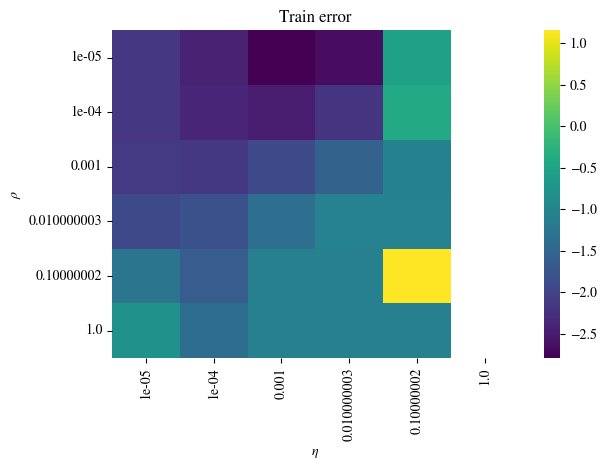

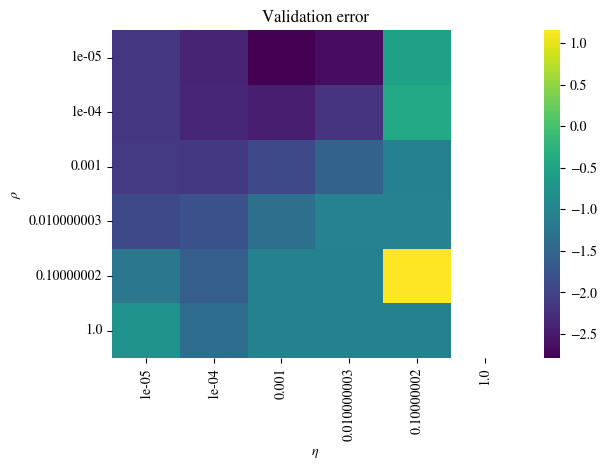

In [17]:
from plotutils import plotHeatmap
import pandas as pd

train_df = pd.DataFrame(np.log10(train_res), index=lmbda_arr, columns=eta_arr)
validation_df = pd.DataFrame(
    np.log10(validation_res),
    index=lmbda_arr,
    columns=eta_arr,
)

plotHeatmap(
    train_df,
    title="Train error",
    savePlots=True,
    showPlots=True,
    figsPath=basePath,
    saveName="train_error_heatmap",
)
plotHeatmap(
    validation_df,
    title="Validation error",
    savePlots=True,
    showPlots=True,
    figsPath=basePath,
    saveName="validation_error_heatmap",
)

100%|██████████| 4000/4000 [00:06<00:00, 588.09it/s]


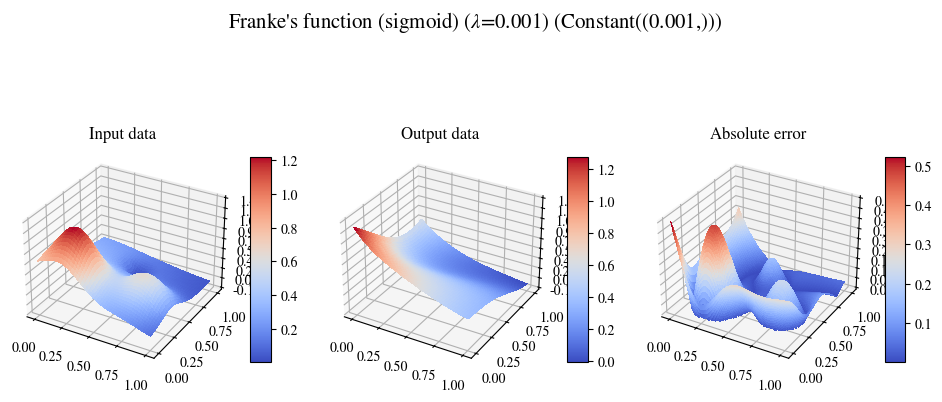

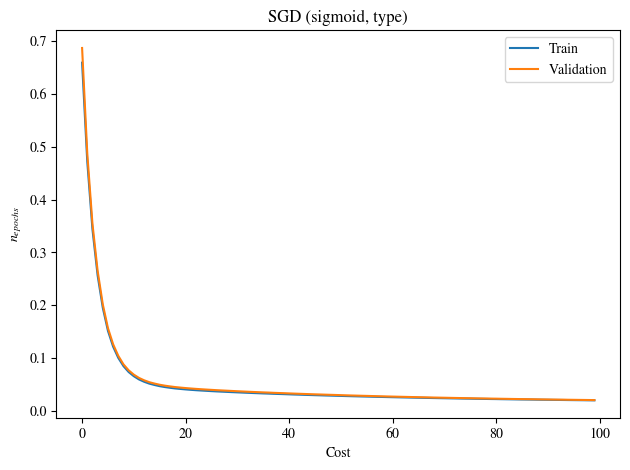

In [8]:
from Schedules import Constant

basePath.mkdir(parents=True, exist_ok=True)
generate_and_plot(
    (75, 75),
    0.001,
    Constant,
    (0.001,),
    sigmoid,
    savePlots=True,
    figsPath=basePath,
    saveName="franke_sgd_constant",
)

100%|██████████| 4000/4000 [00:13<00:00, 297.73it/s]


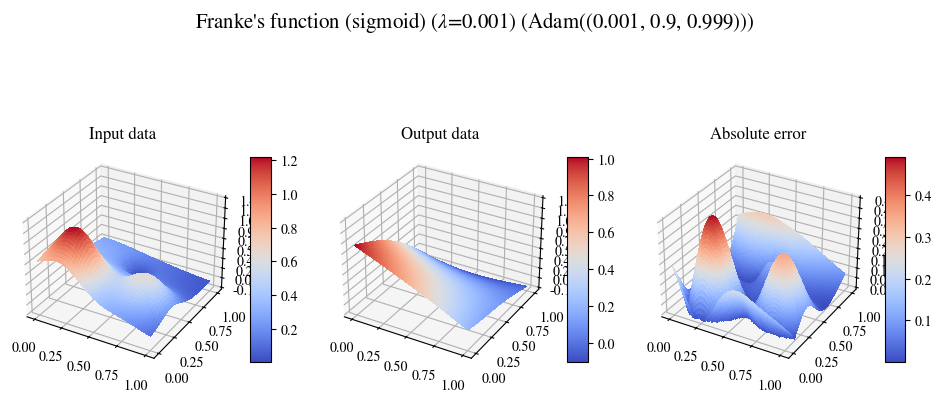

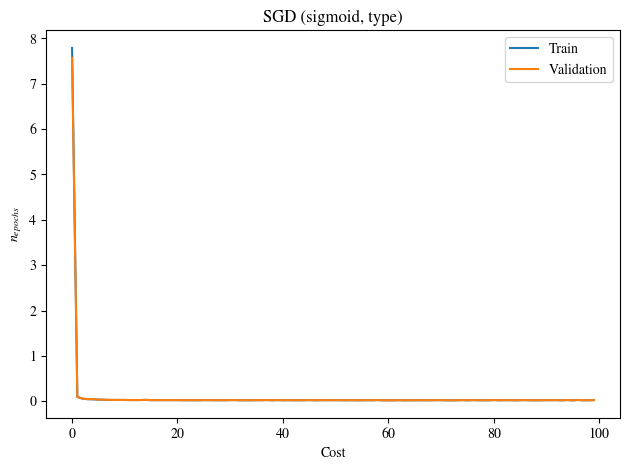

In [10]:
from Schedules import Adam

figsPath = basePath / "franke"
figsPath.mkdir(parents=True, exist_ok=True)
generate_and_plot(
    (1000,),
    0.001,
    Adam,
    (0.001, 0.9, 0.999),
    sigmoid,
    savePlots=True,
    figsPath=figsPath,
    saveName="franke_sgd_constant",
)

100%|██████████| 1000/1000 [00:01<00:00, 509.42it/s]


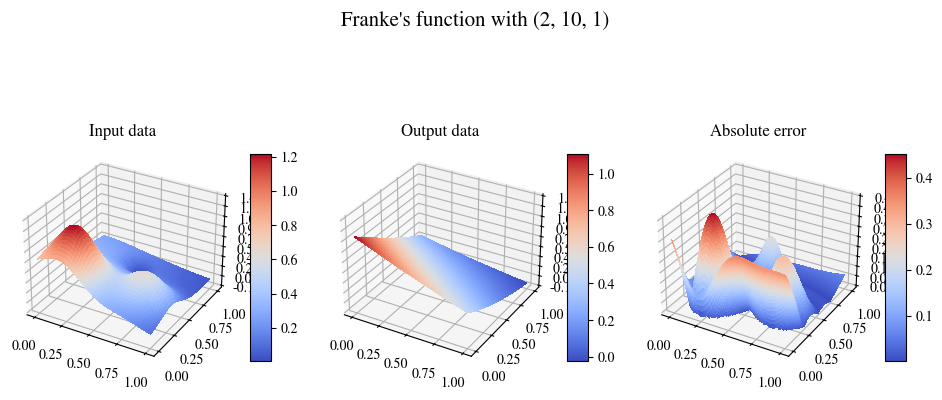

100%|██████████| 1000/1000 [00:01<00:00, 540.83it/s]


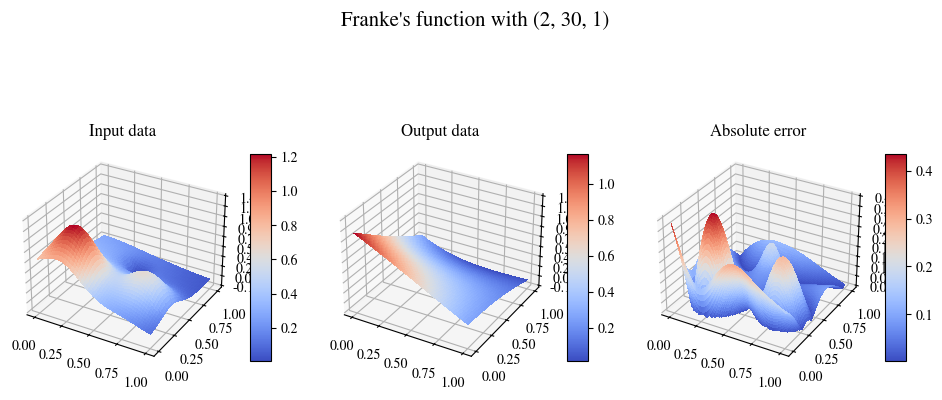

100%|██████████| 1000/1000 [00:02<00:00, 439.32it/s]


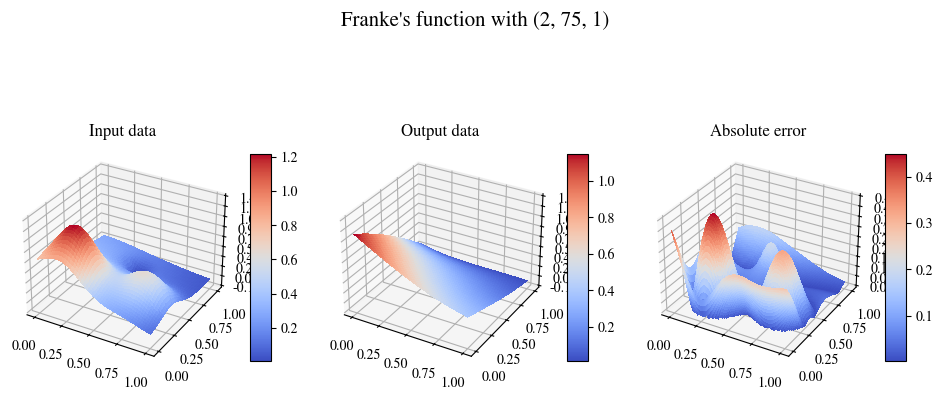

100%|██████████| 1000/1000 [00:03<00:00, 282.57it/s]


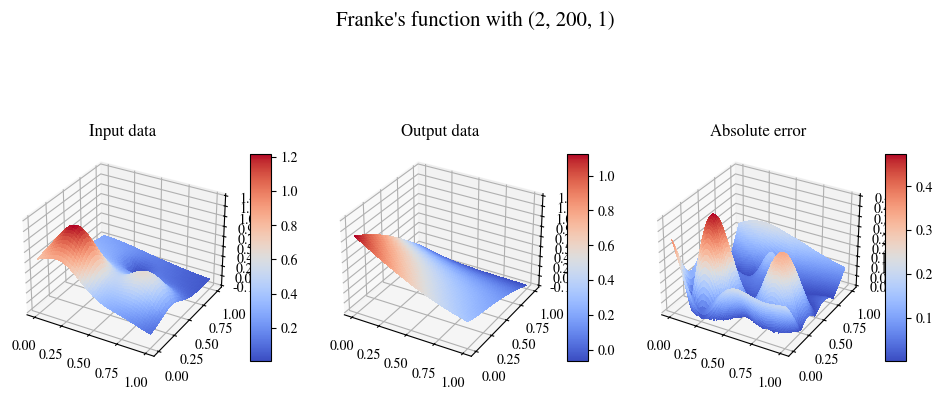

100%|██████████| 1000/1000 [00:03<00:00, 322.35it/s]


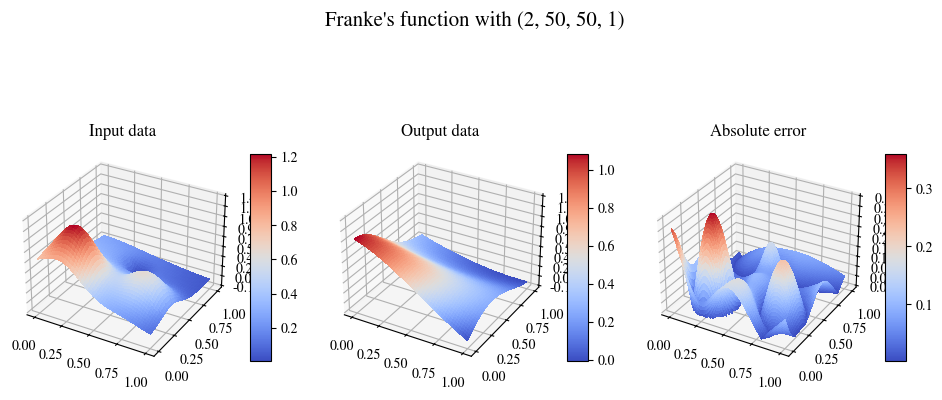

100%|██████████| 1000/1000 [00:03<00:00, 303.63it/s]


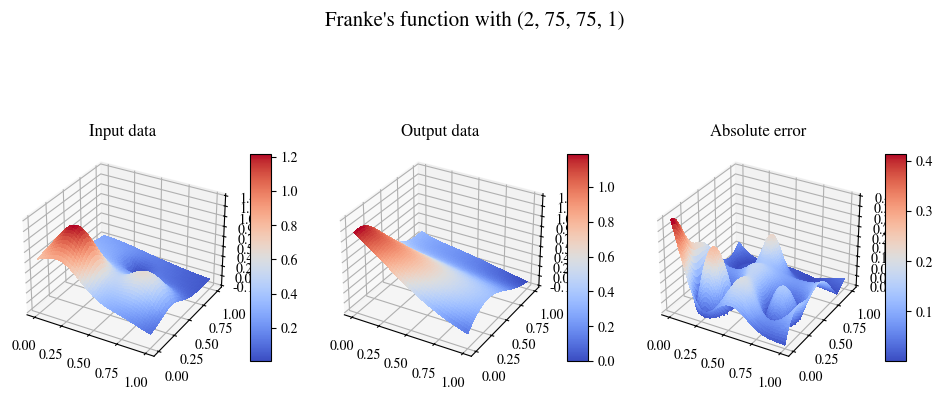

100%|██████████| 1000/1000 [00:04<00:00, 236.11it/s]


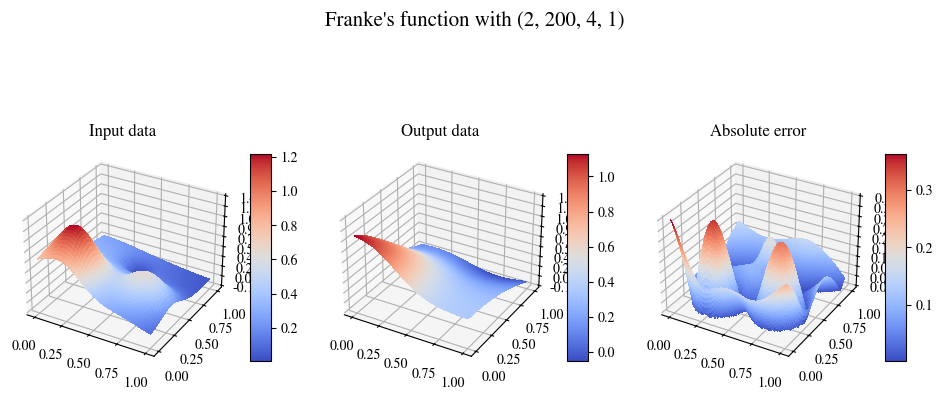

100%|██████████| 1000/1000 [00:04<00:00, 238.25it/s]


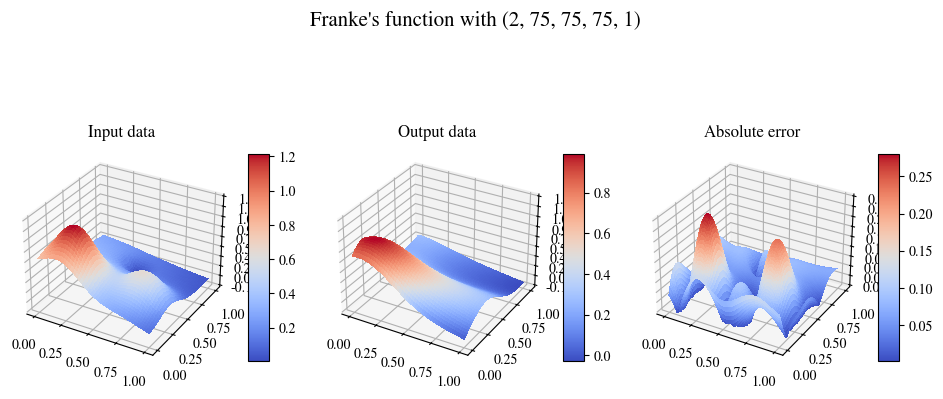

100%|██████████| 1000/1000 [00:09<00:00, 108.55it/s]


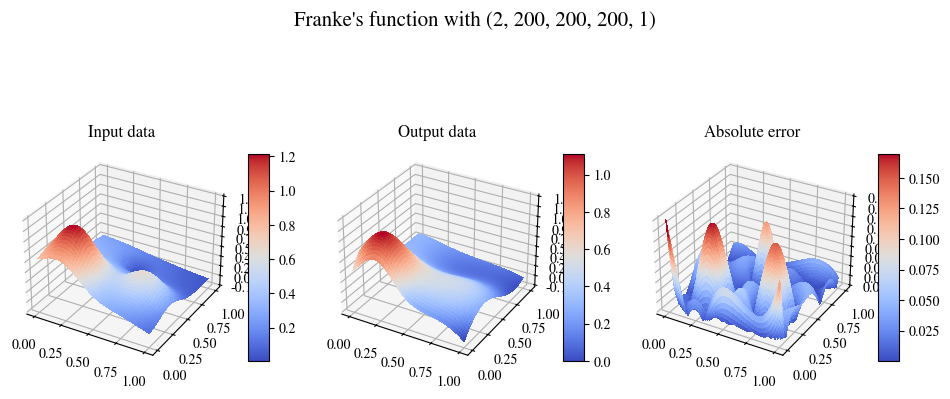

100%|██████████| 1000/1000 [00:06<00:00, 143.50it/s]


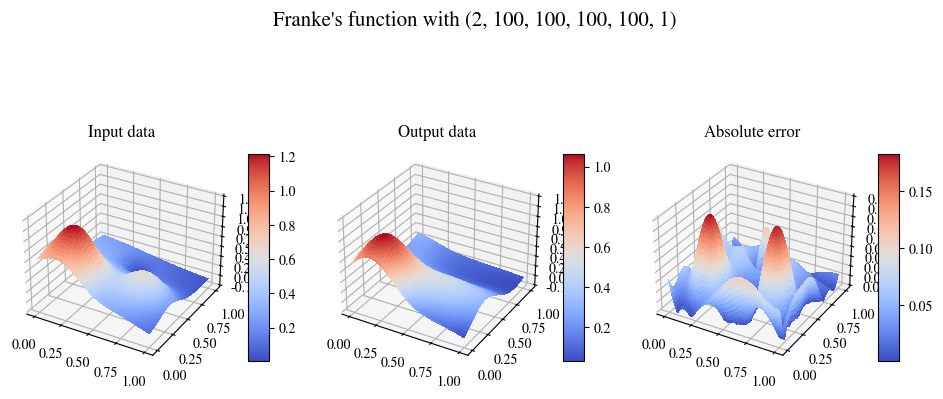

100%|██████████| 1000/1000 [00:12<00:00, 80.53it/s]


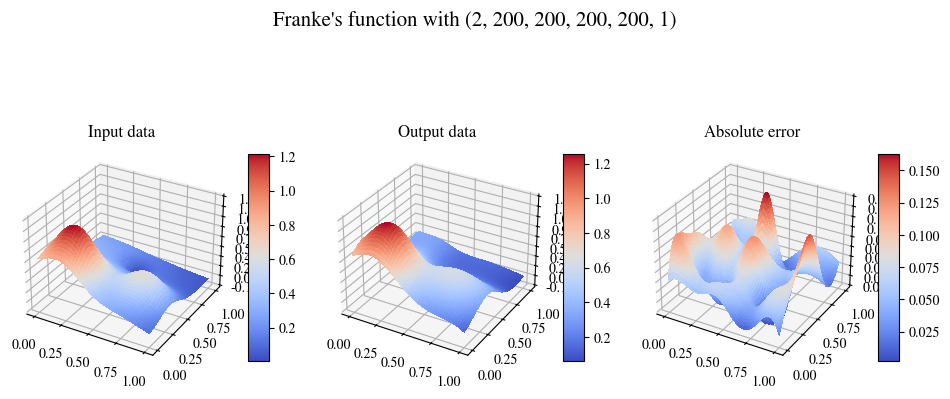

100%|██████████| 1000/1000 [00:16<00:00, 62.15it/s]


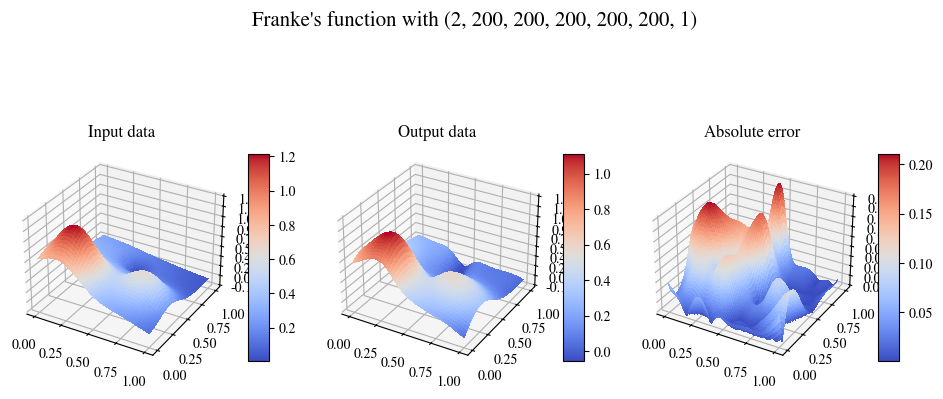

100%|██████████| 1000/1000 [00:18<00:00, 52.88it/s]


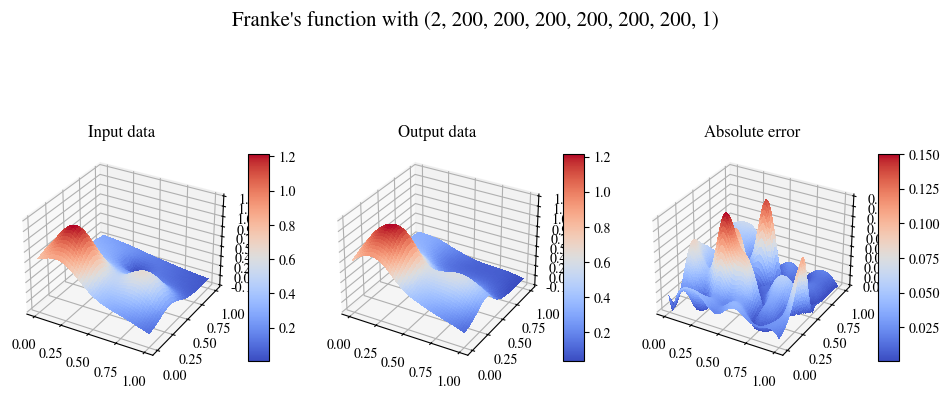

100%|██████████| 1000/1000 [00:22<00:00, 43.88it/s]


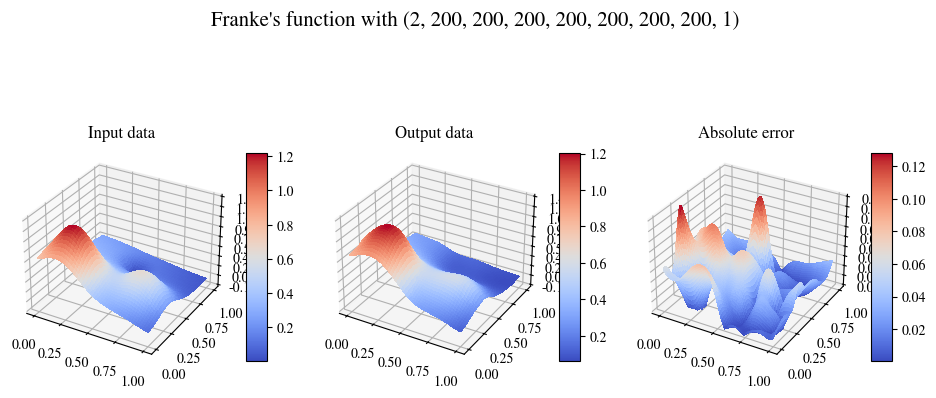

100%|██████████| 1000/1000 [00:25<00:00, 39.32it/s]


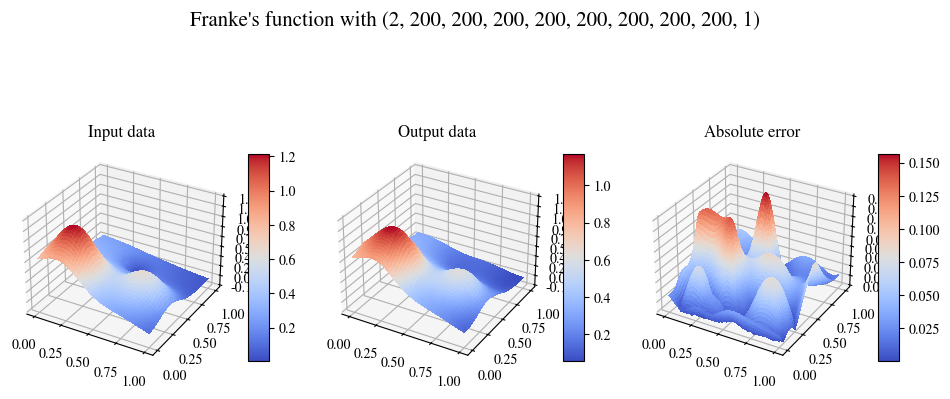

100%|██████████| 1000/1000 [00:28<00:00, 34.75it/s]


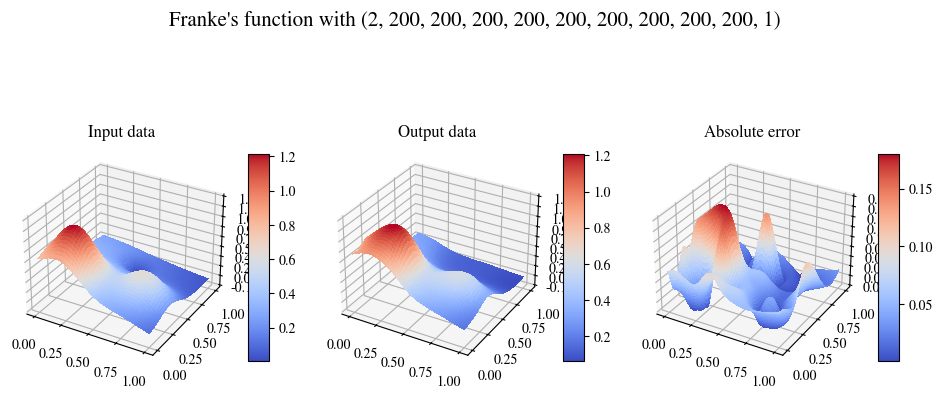

100%|██████████| 1000/1000 [00:35<00:00, 27.92it/s]


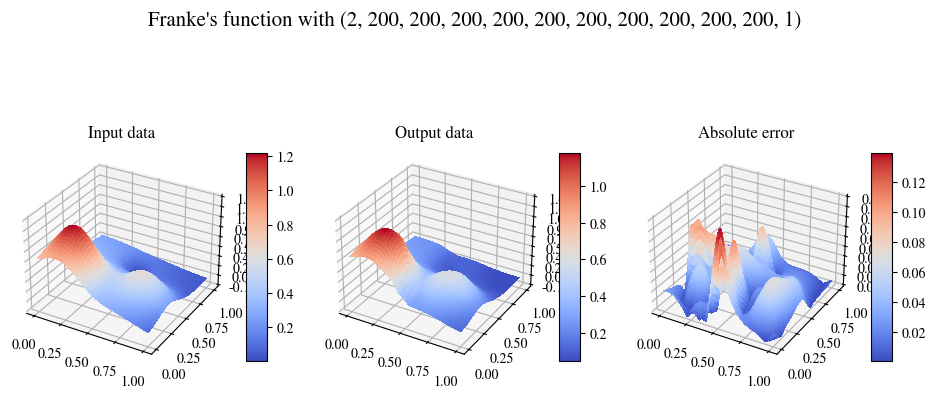

100%|██████████| 1000/1000 [00:41<00:00, 24.16it/s]


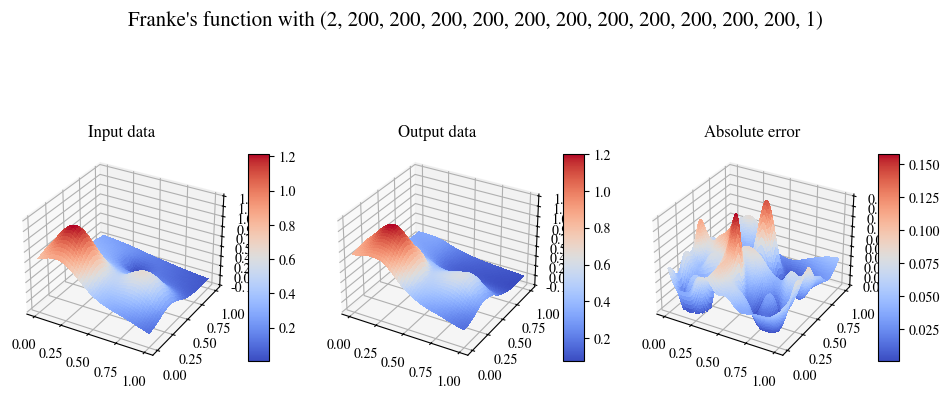

In [7]:
from Schedules import Adam
from Activators import sigmoid, identity
from plotutils import plot_Franke

dimensions = (2, 75, 75, 100, 1)
inner_dimension_list = [
    (10,),
    (30,),
    (75,),
    (200,),
    (50, 50),
    (75, 75),
    (200, 4),
    (75, 75, 75),
    (200, 200, 200),
    (100, 100, 100, 100),
    (200, 200, 200, 200),
    (200, 200, 200, 200, 200),
    (200, 200, 200, 200, 200, 200),
    (200, 200, 200, 200, 200, 200, 200),
    (200, 200, 200, 200, 200, 200, 200, 200),
    (200, 200, 200, 200, 200, 200, 200, 200, 200),
    (200, 200, 200, 200, 200, 200, 200, 200, 200, 200),
    (200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200),
]
for inner_dim in inner_dimension_list:
    dimensions = (2, *inner_dim, 1)
    FFNN = NeuralNet(dimensions, hidden_func=sigmoid, output_func=identity, seed=2023)
    scores = FFNN.fit(
        X_train,
        z_train,
        epochs=100,
        lmbda=0.0001,
        scheduler=Adam(0.001, 0.9, 0.999),
        X_val=X_test,
        target_val=z_test,
        batches=10,
    )
    plot_Franke(FFNN, x, y, z, title=f"Franke's function with {dimensions}")

In [25]:
from Schedules import Adam
from Activators import sigmoid, identity

dimensions = (2, 75, 75, 100, 1)
FFNN = NeuralNet(dimensions, hidden_func=sigmoid, output_func=jit(identity), seed=2023)
scores = FFNN.fit(
    X_train,
    z_train,
    epochs=100,
    lmbda=0.0001,
    scheduler=Adam(0.001, 0.9, 0.999),
    X_val=X_test,
    target_val=z_test,
    batches=10,
)

100%|██████████| 1000/1000 [00:06<00:00, 146.44it/s]


/var/folders/gk/nd3wqtqx291b3hj52v6ll0qw0000gn/T/ipykernel_16926/3104763455.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


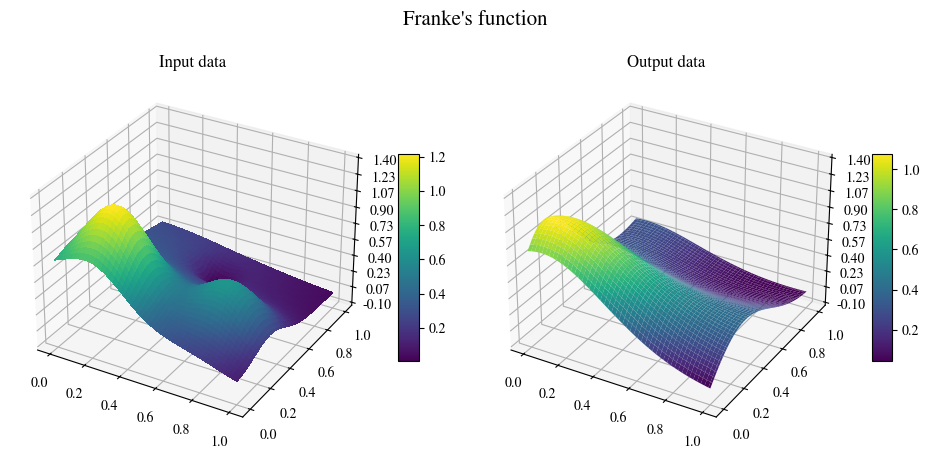

In [26]:
from plotutils import plot_Franke

fig = plot_Franke(FFNN, x, y, z)
fig.show()

100%|██████████| 10000/10000 [00:19<00:00, 514.51it/s]
/var/folders/gk/nd3wqtqx291b3hj52v6ll0qw0000gn/T/ipykernel_29622/964438824.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


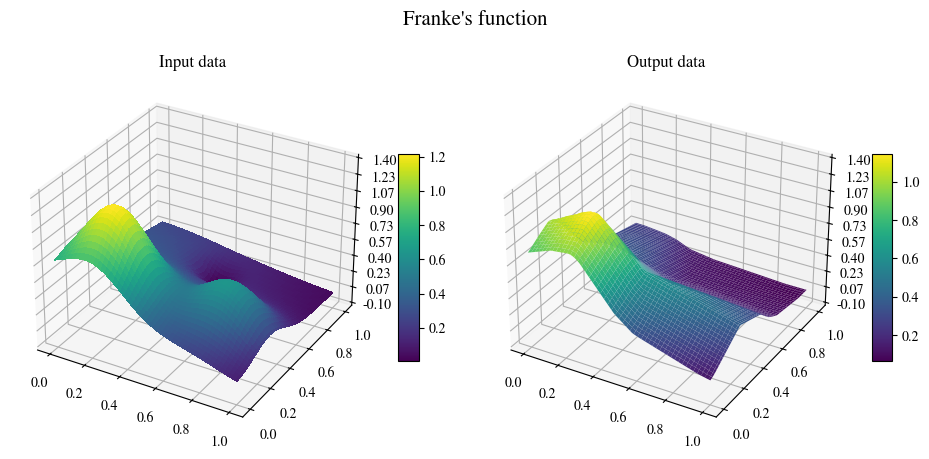

In [30]:
from Schedules import Adam
from Activators import zero_one_clip, identity, RELU, LRELU
from plotutils import plot_Franke
from jax import jit

dimensions = (2, 50, 50, 75, 1)
FFNN = NeuralNet(dimensions, hidden_func=RELU,
                 output_func=jit(identity), seed=2023)
scores = FFNN.fit(
    X_train,
    z_train,
    epochs=200,
    lmbda=0.001,
    scheduler=Adam(0.01, 0.9, 0.999),
    X_val=X_test,
    target_val=z_test,
    batches=50,
)
fig = plot_Franke(FFNN, x, y, z)
fig.show()

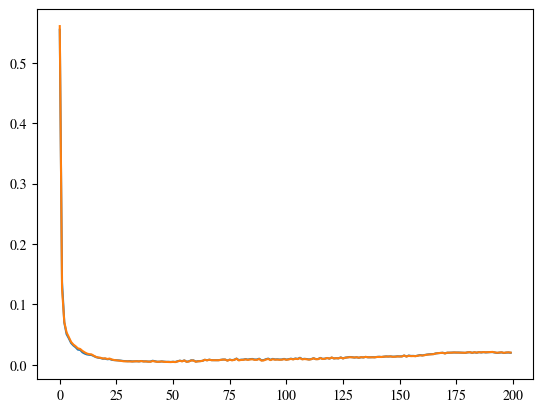

In [8]:
plt.plot(scores["train_errors"])
plt.plot(scores["validation_errors"])

In [18]:
from Schedules import Adam

dimensions = (2, 75, 75, 100, 1)
FFNN = NeuralNet(dimensions, hidden_func=sigmoid, output_func=identity, seed=2023)
scores = FFNN.fit(
    X_train,
    z_train,
    epochs=100,
    lmbda=0.0001,
    scheduler=Adam(0.001, 0.9, 0.999),
    X_val=X_test,
    target_val=z_test,
    batches=10,
)

100%|██████████| 1000/1000 [00:06<00:00, 150.94it/s]


In [19]:
from Schedules import Adam
from Activators import sigmoid

dimensions = (2, 75, 75, 100, 1)
FFNN = NeuralNet(
    dimensions, hidden_func=sigmoid, output_func=jit(lambda x: x), seed=2023
)

In [20]:
scores = FFNN.fit(
    X, z, epochs=250, scheduler=Adam(0.0001, 0.9, 0.999), batches=10, lmbda=0.001
)

100%|██████████| 2500/2500 [00:18<00:00, 138.38it/s]


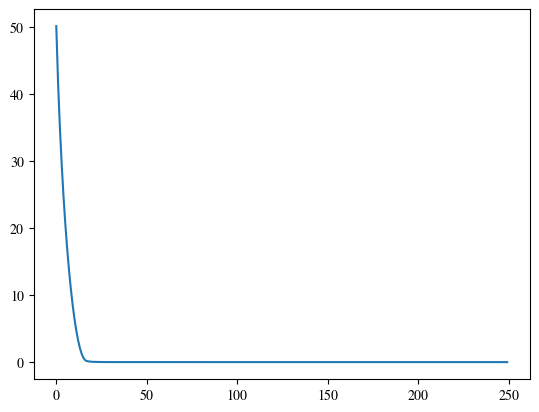

In [12]:
plt.plot(scores["train_errors"])

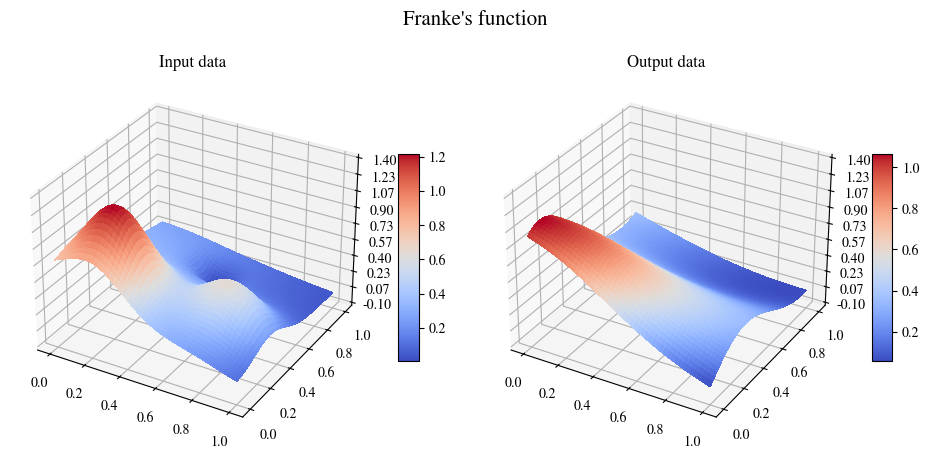

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

xnew = np.linspace(0, 1, 100)
ynew = np.linspace(0, 1, 100)
xnew, ynew = np.meshgrid(xnew, ynew)
znew = FFNN.predict(
    np.c_[xnew.ravel().reshape(-1, 1), ynew.ravel().reshape(-1, 1)]
).reshape(100, 100)

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
surf = ax.plot_surface(
    x,
    y,
    z.reshape(100, 100),
    cmap=cm.coolwarm,
    linewidth=0,
    antialiased=False,
)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
ax.set_title("Input data")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax = fig.add_subplot(1, 2, 2, projection="3d")
surf = ax.plot_surface(
    xnew,
    ynew,
    znew,
    cmap=cm.coolwarm,
    linewidth=0,
    antialiased=False,
)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
ax.set_title("Output data")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

fig.suptitle("Franke's function")

plt.tight_layout()

In [14]:
from Schedules import Adam
from Activators import zero_one_clip

dimensions = (2, 75, 75, 100, 1)
FFNN = NeuralNet(
    dimensions, hidden_func=zero_one_clip, output_func=jit(lambda x: x), seed=2023
)
scores = FFNN.fit(
    X, z, epochs=200, scheduler=Adam(0.001, 0.9, 0.999), batches=100, lmbda=0.0001
)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [01:17<00:00, 259.51it/s]


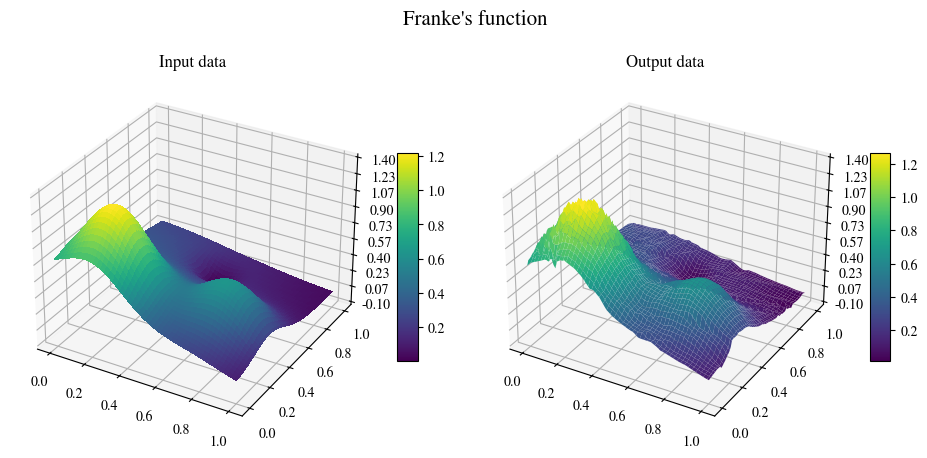

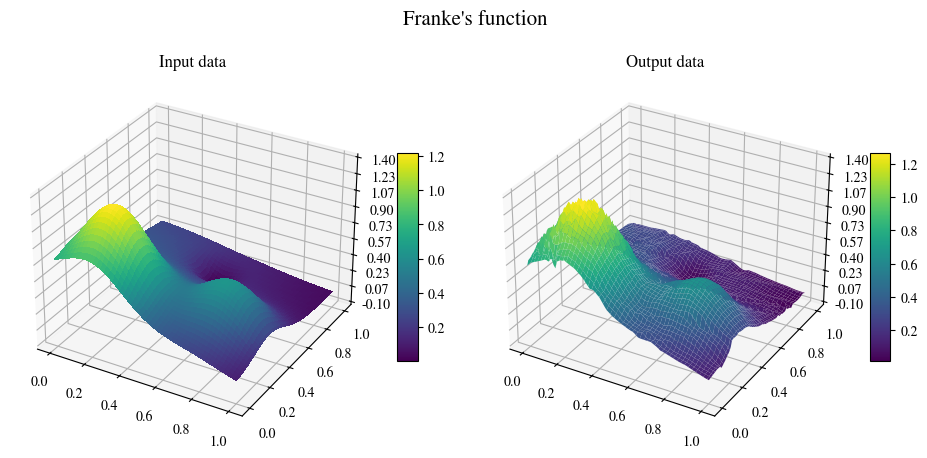

In [17]:
plot_Franke(FFNN, x, y, z)

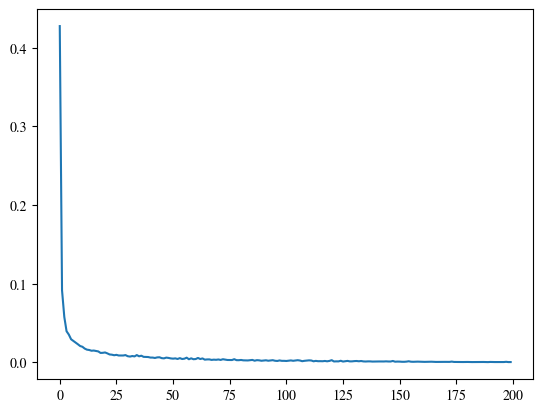

In [15]:
plt.plot(scores["train_errors"])

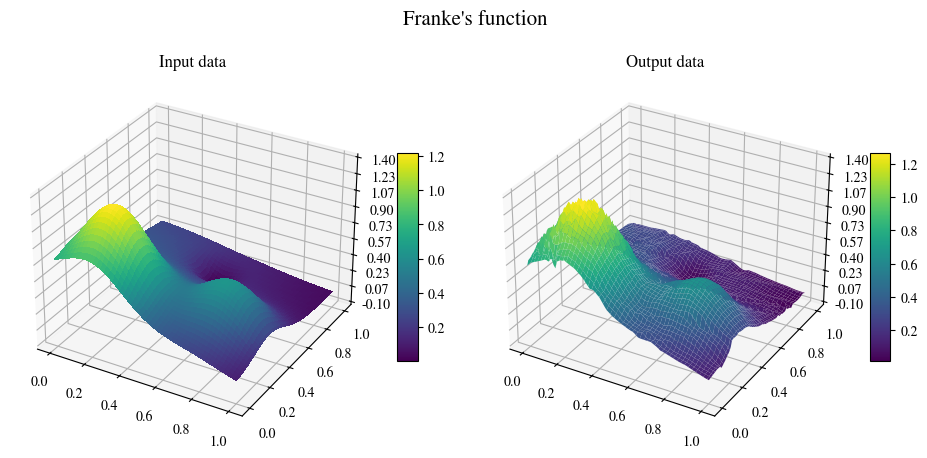

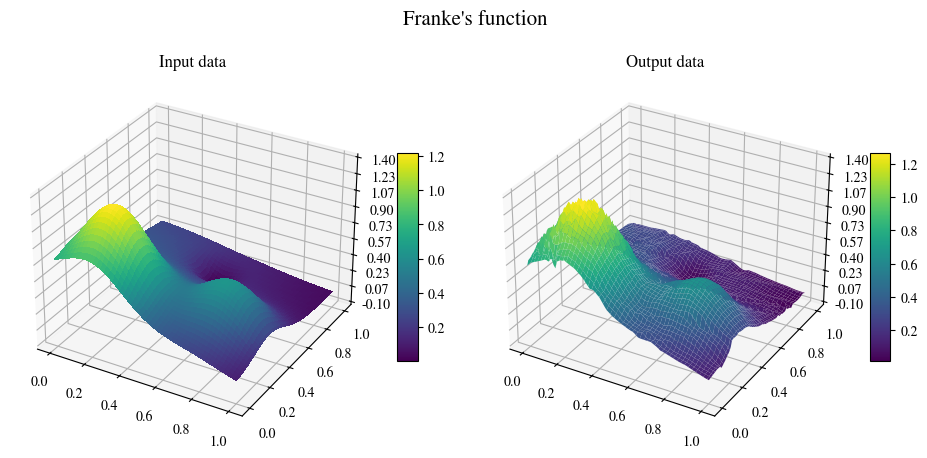

In [16]:
from plotutils import plot_Franke

plot_Franke(FFNN, x, y, z)

In [6]:
from NeuralNetwork import NeuralNet
from Schedules import Adam
from Activators import zero_one_clip

eta_arr = np.logspace(-5, -1, 5)
lmbda_arr = np.logspace(-5, -1, 5)

total_scores = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]
total_FFNN = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]

for i, lmbda in enumerate(lmbda_arr):
    for j, eta in enumerate(eta_arr):
        dimensions = (2, 75, 75, 100, 1)
        FFNN = NeuralNet(
            dimensions,
            hidden_func=zero_one_clip,
            output_func=jit(lambda x: x),
            seed=2023,
        )
        scores = FFNN.fit(
            X_train,
            z_train,
            epochs=200,
            scheduler=Adam(eta, 0.9, 0.999),
            batches=50,
            lmbda=lmbda,
            X_val=X_test,
            target_val=z_test,
        )
        total_scores[i][j] = scores
        total_FFNN[i][j] = FFNN

100%|██████████| 10000/10000 [00:25<00:00, 390.79it/s]


In [8]:
final_val = onp.zeros((len(lmbda_arr), len(eta_arr)))
final_train = onp.zeros((len(lmbda_arr), len(eta_arr)))
for i in range(len(lmbda_arr)):
    for j in range(len(eta_arr)):
        final_val[i, j] = total_scores[i][j]["validation_errors"][-1]
        final_train[i, j] = total_scores[i][j]["train_errors"][-1]

In [18]:
import pandas as pd
from plotutils import plotHeatmap


def plot_error_and_val(final_val, final_train, lmbda_arr, eta_arr):
    df = pd.DataFrame(np.log10(final_val), index=lmbda_arr, columns=eta_arr)
    plotHeatmap(
        df,
        x_label="$\eta$",
        y_label="$\lambda$",
        title=r"$\log_10$ of validation error",
    )

    df = pd.DataFrame(np.log10(final_train), index=lmbda_arr, columns=eta_arr)
    plotHeatmap(
        df, x_label="$\eta$", y_label="$\lambda$", title=r"$\log_10$ of training error"
    )

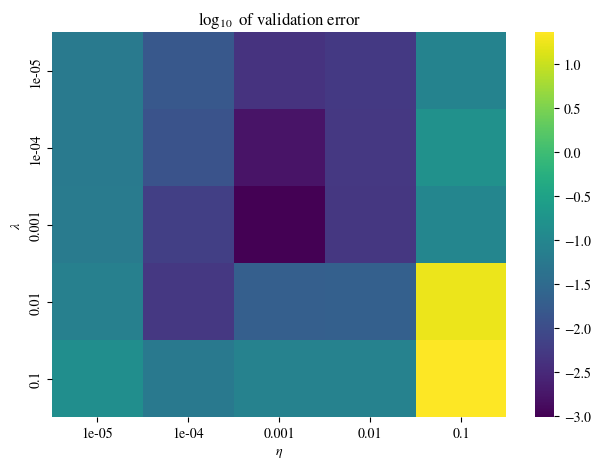

In [12]:
from plotutils import plotHeatmap
import pandas as pd

df = pd.DataFrame(np.log10(final_val), index=lmbda_arr, columns=eta_arr)
plotHeatmap(
    df,
    x_label=r"$\eta$",
    y_label=r"$\lambda$",
    title=r"$\log_{10}$ of validation error",
)

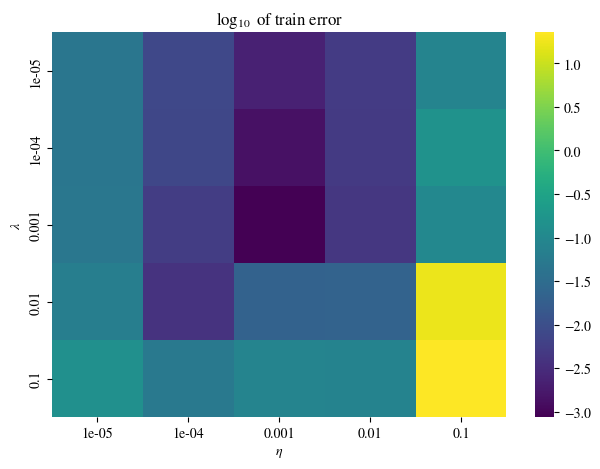

In [14]:
df = pd.DataFrame(np.log10(final_train), index=lmbda_arr, columns=eta_arr)
plotHeatmap(
    df, x_label=r"$\eta$", y_label=r"$\lambda$", title=r"$\log_{10}$ of train error"
)

In [20]:
from NeuralNetwork import NeuralNet
from Schedules import Adam
from Activators import RELU

eta_arr = np.logspace(-5, -1, 5)
lmbda_arr = np.logspace(-5, -1, 5)

total_scores = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]
total_FFNN = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]

for i, lmbda in enumerate(lmbda_arr):
    for j, eta in enumerate(eta_arr):
        dimensions = (2, 75, 75, 100, 1)
        FFNN = NeuralNet(
            dimensions, hidden_func=RELU, output_func=jit(lambda x: x), seed=2023
        )
        scores = FFNN.fit(
            X_train,
            z_train,
            epochs=200,
            scheduler=Adam(eta, 0.9, 0.999),
            batches=50,
            lmbda=lmbda,
            X_val=X_test,
            target_val=z_test,
        )
        total_scores[i][j] = scores
        total_FFNN[i][j] = FFNN

100%|██████████| 10000/10000 [00:21<00:00, 466.61it/s]


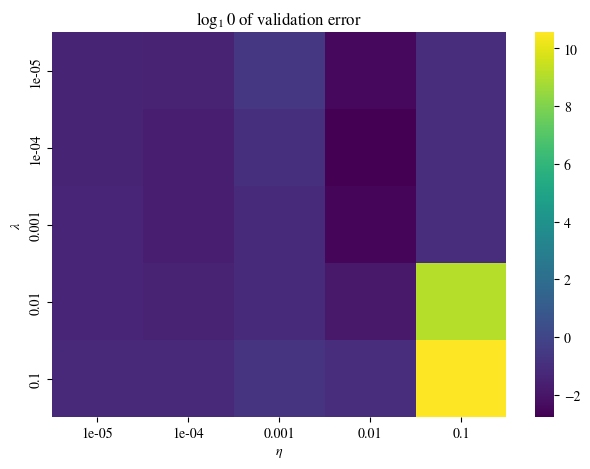

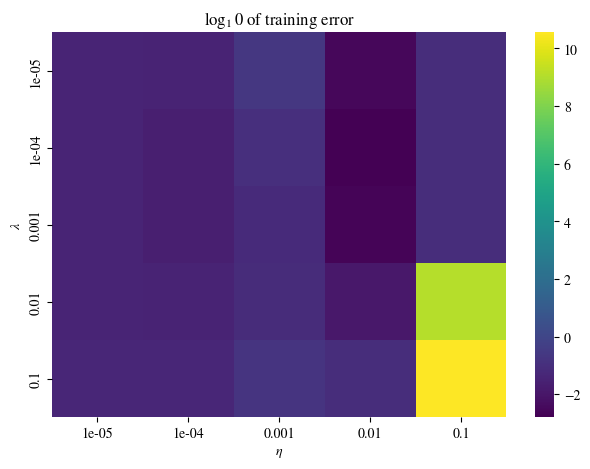

In [21]:
final_val = onp.zeros((len(lmbda_arr), len(eta_arr)))
final_train = onp.zeros((len(lmbda_arr), len(eta_arr)))
for i in range(len(lmbda_arr)):
    for j in range(len(eta_arr)):
        final_val[i, j] = total_scores[i][j]["validation_errors"][-1]
        final_train[i, j] = total_scores[i][j]["train_errors"][-1]

plot_error_and_val(final_val, final_train, lmbda_arr, eta_arr)

In [22]:
from NeuralNetwork import NeuralNet
from Schedules import Adam
from Activators import sigmoid

eta_arr = np.logspace(-5, -1, 5)
lmbda_arr = np.logspace(-5, -1, 5)

total_scores = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]
total_FFNN = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]

for i, lmbda in enumerate(lmbda_arr):
    for j, eta in enumerate(eta_arr):
        dimensions = (2, 75, 75, 100, 1)
        FFNN = NeuralNet(
            dimensions, hidden_func=sigmoid, output_func=jit(lambda x: x), seed=2023
        )
        scores = FFNN.fit(
            X_train,
            z_train,
            epochs=200,
            scheduler=Adam(eta, 0.9, 0.999),
            batches=50,
            lmbda=lmbda,
            X_val=X_test,
            target_val=z_test,
        )
        total_scores[i][j] = scores
        total_FFNN[i][j] = FFNN

100%|██████████| 10000/10000 [00:23<00:00, 432.02it/s]


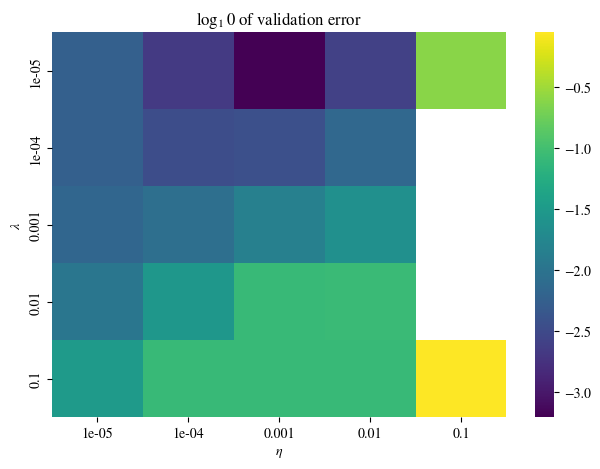

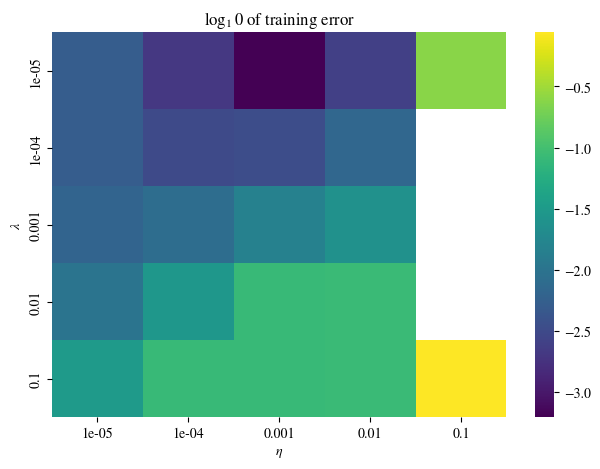

In [23]:
final_val = onp.zeros((len(lmbda_arr), len(eta_arr)))
final_train = onp.zeros((len(lmbda_arr), len(eta_arr)))
for i in range(len(lmbda_arr)):
    for j in range(len(eta_arr)):
        final_val[i, j] = total_scores[i][j]["validation_errors"][-1]
        final_train[i, j] = total_scores[i][j]["train_errors"][-1]

plot_error_and_val(final_val, final_train, lmbda_arr, eta_arr)

In [24]:
from NeuralNetwork import NeuralNet
from Schedules import Adam
from Activators import LRELU

eta_arr = np.logspace(-5, -1, 5)
lmbda_arr = np.logspace(-5, -1, 5)

total_scores = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]
total_FFNN = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]

for i, lmbda in enumerate(lmbda_arr):
    for j, eta in enumerate(eta_arr):
        dimensions = (2, 75, 75, 100, 1)
        FFNN = NeuralNet(
            dimensions, hidden_func=LRELU, output_func=jit(lambda x: x), seed=2023
        )
        scores = FFNN.fit(
            X_train,
            z_train,
            epochs=200,
            scheduler=Adam(eta, 0.9, 0.999),
            batches=50,
            lmbda=lmbda,
            X_val=X_test,
            target_val=z_test,
        )
        total_scores[i][j] = scores
        total_FFNN[i][j] = FFNN

100%|██████████| 10000/10000 [00:24<00:00, 413.01it/s]


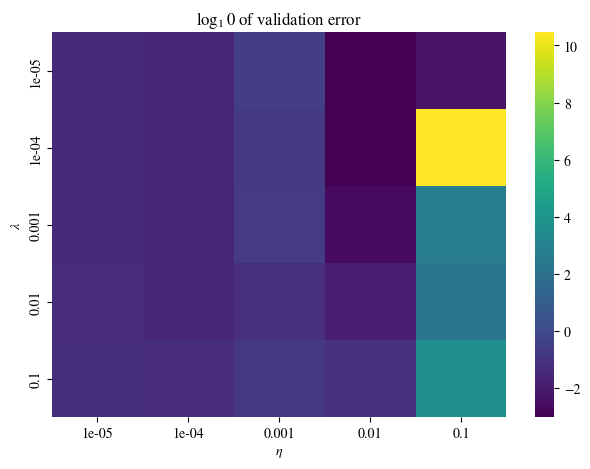

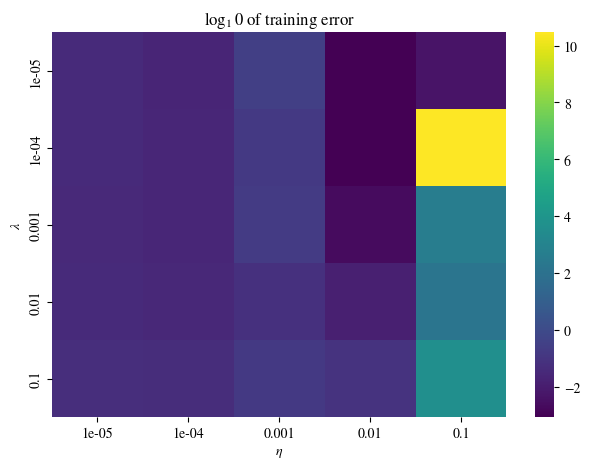

In [25]:
final_val = onp.zeros((len(lmbda_arr), len(eta_arr)))
final_train = onp.zeros((len(lmbda_arr), len(eta_arr)))
for i in range(len(lmbda_arr)):
    for j in range(len(eta_arr)):
        final_val[i, j] = total_scores[i][j]["validation_errors"][-1]
        final_train[i, j] = total_scores[i][j]["train_errors"][-1]

plot_error_and_val(final_val, final_train, lmbda_arr, eta_arr)

In [26]:
from NeuralNetwork import NeuralNet
from Schedules import Adagrad
from Activators import zero_one_clip

eta_arr = np.logspace(-5, -1, 5)
lmbda_arr = np.logspace(-5, -1, 5)

total_scores = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]
total_FFNN = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]

for i, lmbda in enumerate(lmbda_arr):
    for j, eta in enumerate(eta_arr):
        dimensions = (2, 75, 75, 100, 1)
        FFNN = NeuralNet(
            dimensions,
            hidden_func=zero_one_clip,
            output_func=jit(lambda x: x),
            seed=2023,
        )
        scores = FFNN.fit(
            X_train,
            z_train,
            epochs=200,
            scheduler=Adagrad(eta),
            batches=50,
            lmbda=lmbda,
            X_val=X_test,
            target_val=z_test,
        )
        total_scores[i][j] = scores
        total_FFNN[i][j] = FFNN

100%|██████████| 10000/10000 [00:20<00:00, 480.05it/s]


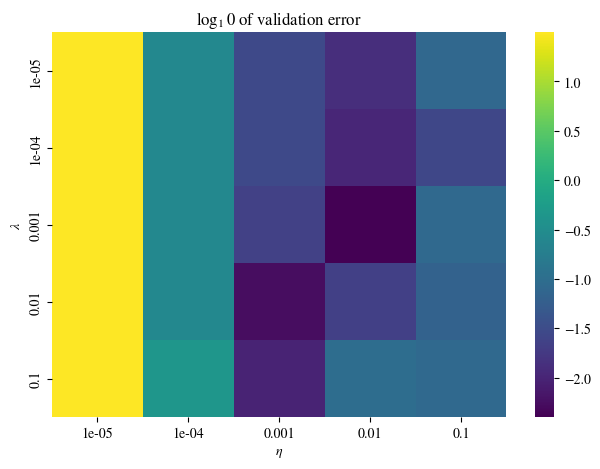

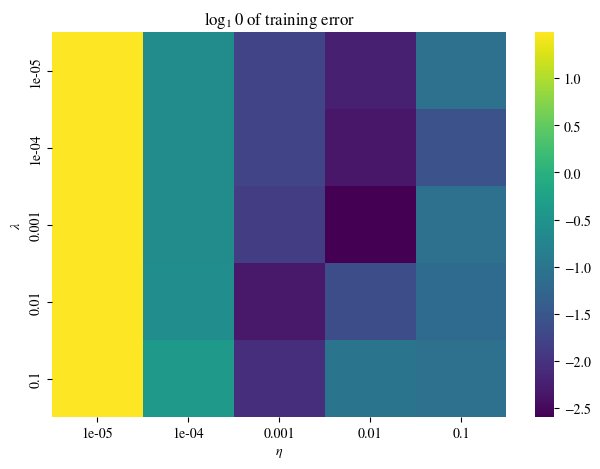

In [27]:
final_val = onp.zeros((len(lmbda_arr), len(eta_arr)))
final_train = onp.zeros((len(lmbda_arr), len(eta_arr)))
for i in range(len(lmbda_arr)):
    for j in range(len(eta_arr)):
        final_val[i, j] = total_scores[i][j]["validation_errors"][-1]
        final_train[i, j] = total_scores[i][j]["train_errors"][-1]

plot_error_and_val(final_val, final_train, lmbda_arr, eta_arr)

In [28]:
from NeuralNetwork import NeuralNet
from Schedules import AdagradMomentum
from Activators import zero_one_clip

eta_arr = np.logspace(-5, -1, 5)
lmbda_arr = np.logspace(-5, -1, 5)

total_scores = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]
total_FFNN = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]

for i, lmbda in enumerate(lmbda_arr):
    for j, eta in enumerate(eta_arr):
        dimensions = (2, 75, 75, 100, 1)
        FFNN = NeuralNet(
            dimensions,
            hidden_func=zero_one_clip,
            output_func=jit(lambda x: x),
            seed=2023,
        )
        scores = FFNN.fit(
            X_train,
            z_train,
            epochs=200,
            scheduler=AdagradMomentum(eta, 0.9),
            batches=50,
            lmbda=lmbda,
            X_val=X_test,
            target_val=z_test,
        )
        total_scores[i][j] = scores
        total_FFNN[i][j] = FFNN

100%|██████████| 10000/10000 [00:21<00:00, 469.44it/s]


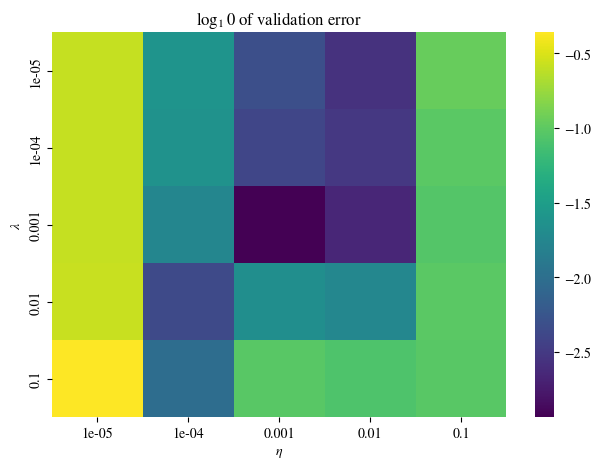

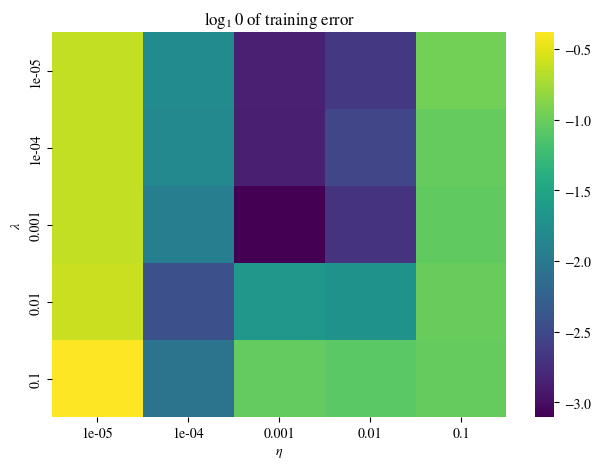

In [29]:
final_val = onp.zeros((len(lmbda_arr), len(eta_arr)))
final_train = onp.zeros((len(lmbda_arr), len(eta_arr)))
for i in range(len(lmbda_arr)):
    for j in range(len(eta_arr)):
        final_val[i, j] = total_scores[i][j]["validation_errors"][-1]
        final_train[i, j] = total_scores[i][j]["train_errors"][-1]

plot_error_and_val(final_val, final_train, lmbda_arr, eta_arr)

100%|██████████| 10000/10000 [00:21<00:00, 474.09it/s]


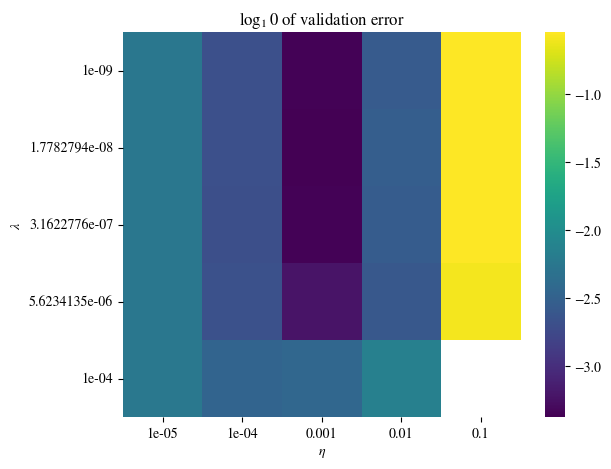

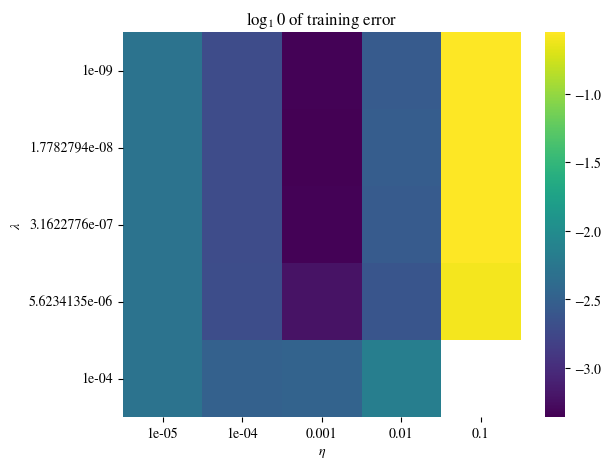

In [31]:
from NeuralNetwork import NeuralNet
from Schedules import Adam
from Activators import sigmoid

eta_arr = np.logspace(-5, -1, 5)
lmbda_arr = np.logspace(-9, -4, 5)

total_scores = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]
total_FFNN = [[None for j in range(len(eta_arr))] for i in range(len(lmbda_arr))]

for i, lmbda in enumerate(lmbda_arr):
    for j, eta in enumerate(eta_arr):
        dimensions = (2, 75, 75, 100, 1)
        FFNN = NeuralNet(
            dimensions, hidden_func=sigmoid, output_func=jit(lambda x: x), seed=2023
        )
        scores = FFNN.fit(
            X_train,
            z_train,
            epochs=200,
            scheduler=Adam(eta, 0.9, 0.999),
            batches=50,
            lmbda=lmbda,
            X_val=X_test,
            target_val=z_test,
        )
        total_scores[i][j] = scores
        total_FFNN[i][j] = FFNN

final_val = onp.zeros((len(lmbda_arr), len(eta_arr)))
final_train = onp.zeros((len(lmbda_arr), len(eta_arr)))
for i in range(len(lmbda_arr)):
    for j in range(len(eta_arr)):
        final_val[i, j] = total_scores[i][j]["validation_errors"][-1]
        final_train[i, j] = total_scores[i][j]["train_errors"][-1]

plot_error_and_val(final_val, final_train, lmbda_arr, eta_arr)

In [5]:
from Activators import sigmoid
from NeuralNetwork import NeuralNet
from Schedules import Adam

dimensions = (2, 75, 75, 100, 1)
FFNN = NeuralNet(
    dimensions, hidden_func=sigmoid, output_func=jit(lambda x: x), seed=2023
)
scores = FFNN.fit(
    X_train,
    z_train,
    epochs=200,
    scheduler=Adam(0.001, 0.9, 0.999),
    batches=50,
    lmbda=1e-7,
    X_val=X_test,
    target_val=z_test,
)

100%|██████████| 10000/10000 [00:26<00:00, 373.83it/s]


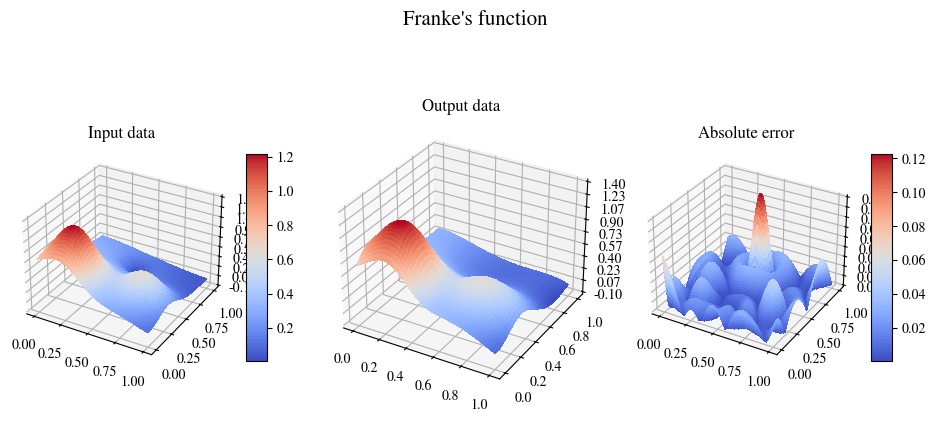

In [6]:
from plotutils import plot_Franke

plot_Franke(FFNN, x, y, z)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:24<00:00, 405.13it/s]


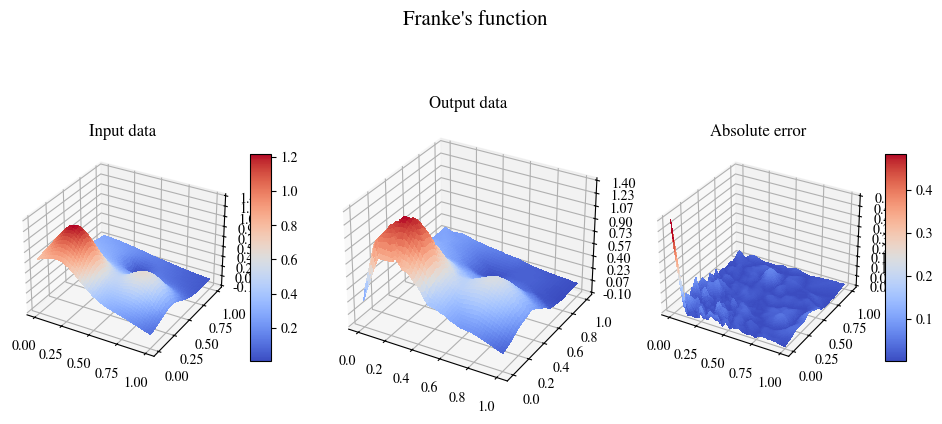

In [12]:
from plotutils import plot_Franke
from Activators import zero_one_clip
from NeuralNetwork import NeuralNet
from Schedules import AdagradMomentum

dimensions = (2, 75, 75, 100, 1)
FFNN = NeuralNet(
    dimensions, hidden_func=zero_one_clip, output_func=jit(lambda x: x), seed=2023
)
scores = FFNN.fit(
    X_train,
    z_train,
    epochs=200,
    scheduler=AdagradMomentum(0.001, 0.9),
    batches=50,
    lmbda=0.001,
    X_val=X_test,
    target_val=z_test,
)

plot_Franke(FFNN, x, y, z)

100%|██████████| 10000/10000 [00:25<00:00, 394.72it/s]


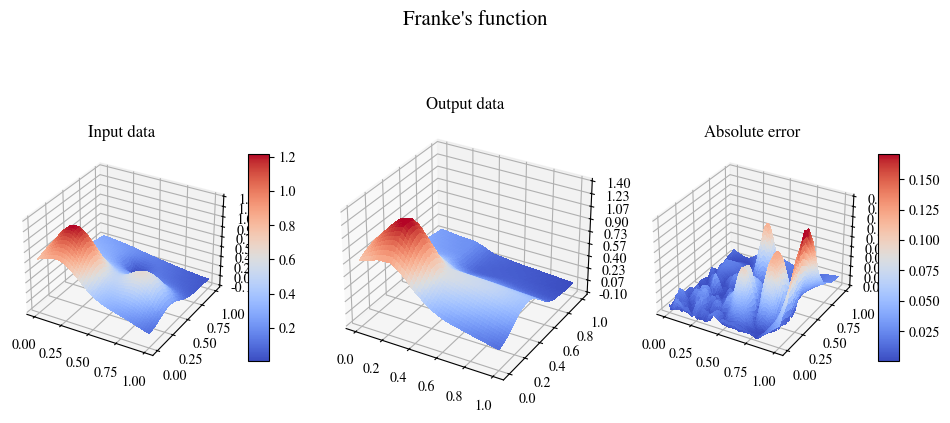

In [14]:
from plotutils import plot_Franke
from Activators import LRELU
from NeuralNetwork import NeuralNet
from Schedules import Adam

dimensions = (2, 75, 75, 100, 1)
FFNN = NeuralNet(dimensions, hidden_func=LRELU,
                 output_func=jit(lambda x: x), seed=2023)
scores = FFNN.fit(
    X_train,
    z_train,
    epochs=200,
    scheduler=Adam(0.01, 0.9, 0.999),
    batches=50,
    lmbda=1e-4,
    X_val=X_test,
    target_val=z_test,
)

plot_Franke(FFNN, x, y, z)

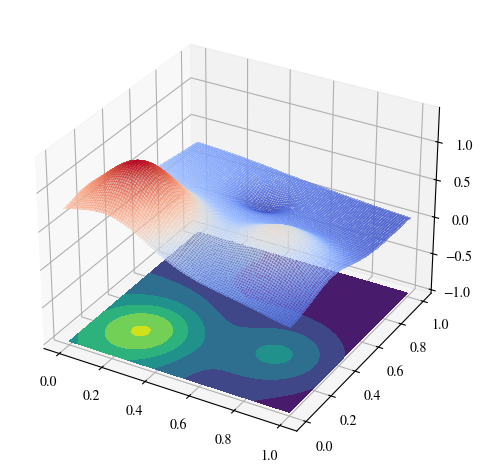

In [79]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(
    x,
    y,
    # z,
    z.reshape(x.shape),
    cmap="coolwarm",
    linewidth=0,
    antialiased=False,
    rstride=1,
    cstride=1,
    alpha=0.5,
)
ax.set_zlim(-1, 1.4)
ax.contourf(x, y, z.reshape(x.shape), offset=-1, cmap="viridis")  # , offset=-1)
fig.tight_layout()

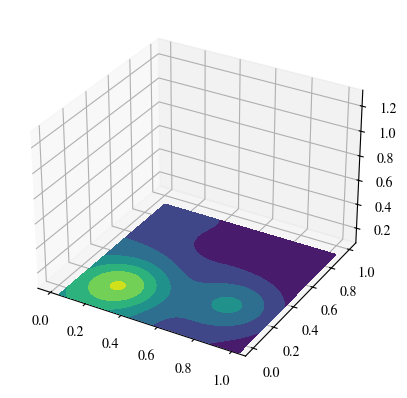

In [61]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(projection="3d")
plt.contourf(x, y, z.reshape(x.shape), offset=0, cmap="viridis")
plt.show()

In [ ]:
plot_Franke(FFNN, x, y, z)